In [1]:
!pip install textblob

In [2]:
import pandas as pd
import nltk
import os
import numpy as np
import json
import seaborn as sns

# for nlp tasks
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import tweepy as tp
import matplotlib.pyplot as plt
import time
import string

from textblob import TextBlob
from datetime import datetime
#from dotenv import load_dotenv


In [3]:
# date: 1/31 - 2/6
    # chose which tweets based on whether the tweet had #sf or #sanfrancisco --> 
    #in place of geotagged tweets (can talk abt how geotagged tweets not representative)
    
    # ~ 10,000 tweets with that filter per week
sftweetsfeb6 = pd.read_csv('sftweets(feb6).csv')

In [4]:
# date: 2/5 - 2/11
sftweetsfeb11 = pd.read_csv('sftweets(feb11).csv')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (31,39,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
sftweetsmar7 = pd.read_csv('sftweets(mar7).csv')

In [6]:
sftweetsmar19 = pd.read_csv('sftweets(mar19).csv')

In [7]:
sftweetsmar29 = pd.read_csv('sftweets(mar29).csv')

In [8]:
sftweetsapr5 = pd.read_csv('sftweets(apr5).csv')

In [9]:
sftweetsapr11 = pd.read_csv('sftweets(apr11).csv')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (39,41,42,43,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
sftweetsapr18 = pd.read_csv('sftweets(apr18).csv')

In [11]:
def remove_common_ids(df_lst): #dfs is list of df's
    new_df = pd.concat(df_lst).drop_duplicates(subset = ['id'])
    new_df = new_df.sort_values(by = 'created_at').reset_index(drop = True) # sort values by created at time
    return new_df

In [12]:
sf_tweets = remove_common_ids([sftweetsfeb6, sftweetsfeb11, sftweetsmar7, sftweetsmar19, sftweetsmar29, sftweetsapr5, sftweetsapr11, sftweetsapr18])

# clean data for nlp
* remove stopwords & punctuation
* remove rows without crime
* remove repeated rows

In [13]:
# https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524#:~:text=TextBlob%20is%20a%20simple%20library,classifying%20negative%20and%20positive%20words.
def remove_punctuation(tweet):
    '''
    This function will remove all punctuations from the tweet passed in
    '''
    return ''.join(ch for ch in tweet if ch not in set(string.punctuation))

def remove_sw(tweet):
    '''
    This function will remove all stopwords from the tweet passed in
    '''
    sw = set(stopwords.words('english'))
    tweet=tweet.lower()
    tweet = ' '.join([w for w in tweet.split(' ') if w not in sw])
    return tweet

sf_tweets['cleaned_tweet'] = sf_tweets['text'].apply(remove_punctuation)
sf_tweets['cleaned_tweet'] = sf_tweets['text'].apply(remove_sw)


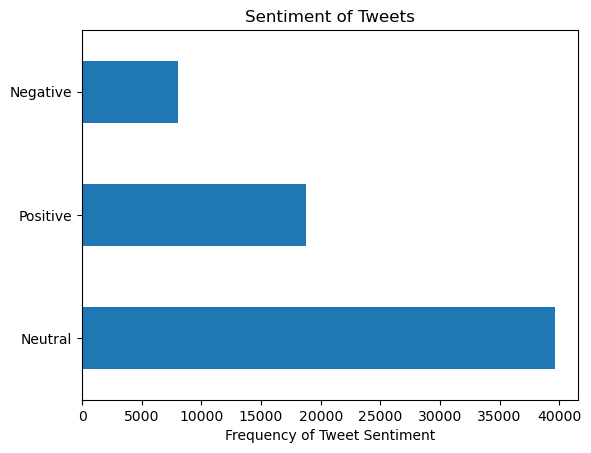

In [14]:
#https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524#:~:text=TextBlob%20is%20a%20simple%20library,classifying%20negative%20and%20positive%20words.
def tweet_sentiment(tweet):
    '''
    Identify the sentiment associated to a tweet.
    
    params:
        tweet (String) : The stirng you want the sentiment of
        
    returns:
        A score between -1 and 1, where values greater than 0
        would indicate a positive sentiment and values less
        than 0 would be negative. Values = 0 is a neutral
        sentiment tweet.
    '''
    tb = TextBlob(tweet)
    score = tb.sentiment.polarity
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
      
sf_tweets['tweet_sentiment'] = sf_tweets['cleaned_tweet'].apply(tweet_sentiment)

plt.clf()
sf_tweets['tweet_sentiment'].value_counts().plot(kind = 'barh')
plt.title('Sentiment of Tweets')
plt.xlabel('Frequency of Tweet Sentiment')
plt.show()

# Figure out frequency / proportion of negative tweets daily
    # then compare the proportion to frequency of crime incident reports in police reports

In [15]:
sf_tweets['created_at'] = pd.to_datetime(sf_tweets['created_at']).dt.date
sf_tweets[['created_at', 'tweet_sentiment']]

,created_at,tweet_sentiment
0,2023-01-31,Positive
1,2023-01-31,Positive
2,2023-01-31,Positive
3,2023-01-31,Neutral
4,2023-01-31,Positive
...,...,...
66423,2023-04-18,Neutral
66424,2023-04-18,Neutral
66425,2023-04-18,Neutral
66426,2023-04-18,Positive


In [16]:
# calculate frequency
# neg = 1, pos / neut = 0
sf_tweets.loc[sf_tweets["tweet_sentiment"] == "Negative", "tweet_sentiment"] = 1
sf_tweets.loc[sf_tweets["tweet_sentiment"] == "Positive", "tweet_sentiment"] = 0
sf_tweets.loc[sf_tweets["tweet_sentiment"] == "Neutral", "tweet_sentiment"] = 0

In [17]:
sf_tweets[['created_at', 'tweet_sentiment']]

,created_at,tweet_sentiment
0,2023-01-31,0
1,2023-01-31,0
2,2023-01-31,0
3,2023-01-31,0
4,2023-01-31,0
...,...,...
66423,2023-04-18,0
66424,2023-04-18,0
66425,2023-04-18,0
66426,2023-04-18,0


In [18]:
count_neg_tweets = sf_tweets[['created_at', 'tweet_sentiment']].groupby('created_at').sum().reset_index()
count_neg_tweets
# date and count of negative tweets

,created_at,tweet_sentiment
0,2023-01-31,185
1,2023-02-01,236
2,2023-02-02,274
3,2023-02-03,295
4,2023-02-04,213
5,2023-02-05,208
6,2023-02-06,190
7,2023-02-07,242
8,2023-02-08,129
9,2023-02-09,175


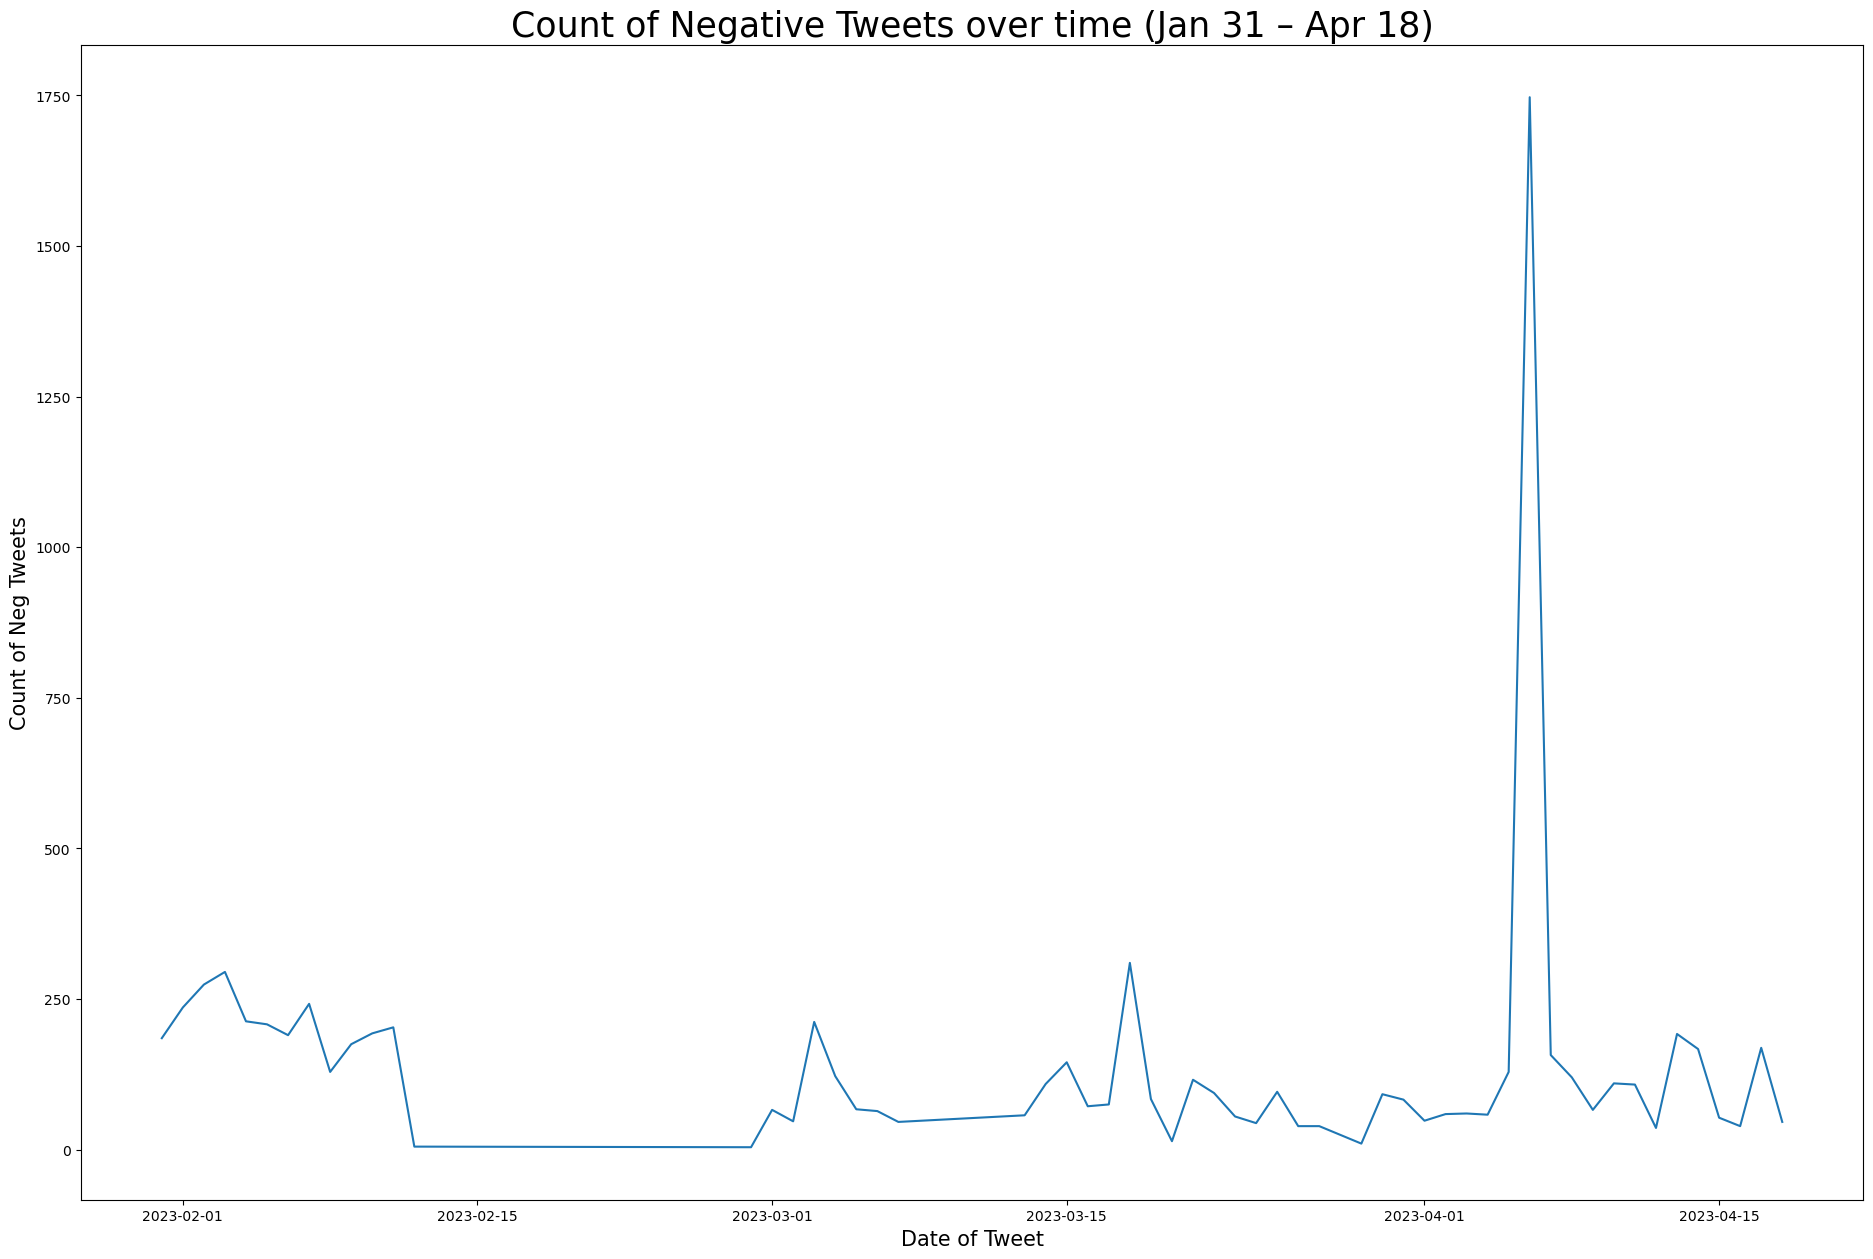

In [19]:
fig, ax = plt.subplots()
plot = sns.lineplot(data=count_neg_tweets, x="created_at", y="tweet_sentiment")
fig.set_size_inches(23, 15)
plt.xlabel('Date of Tweet', fontsize = 15); # binned by day
plt.ylabel('Count of Neg Tweets', fontsize = 15);
plt.title('Count of Negative Tweets over time (Jan 31 – Apr 18)', fontsize = 25);

In [20]:
# calculate proportion of negative tweets for a given day
prop_neg_tweets = (sf_tweets[['created_at', 'tweet_sentiment']].groupby('created_at').sum()['tweet_sentiment'] /
 sf_tweets[['created_at', 'tweet_sentiment']].
 groupby('created_at').count()['tweet_sentiment']).to_frame().reset_index()

prop_neg_tweets

,created_at,tweet_sentiment
0,2023-01-31,0.129461
1,2023-02-01,0.147870
2,2023-02-02,0.166161
3,2023-02-03,0.176330
4,2023-02-04,0.171222
5,2023-02-05,0.180712
6,2023-02-06,0.145371
7,2023-02-07,0.163403
8,2023-02-08,0.106612
9,2023-02-09,0.121275


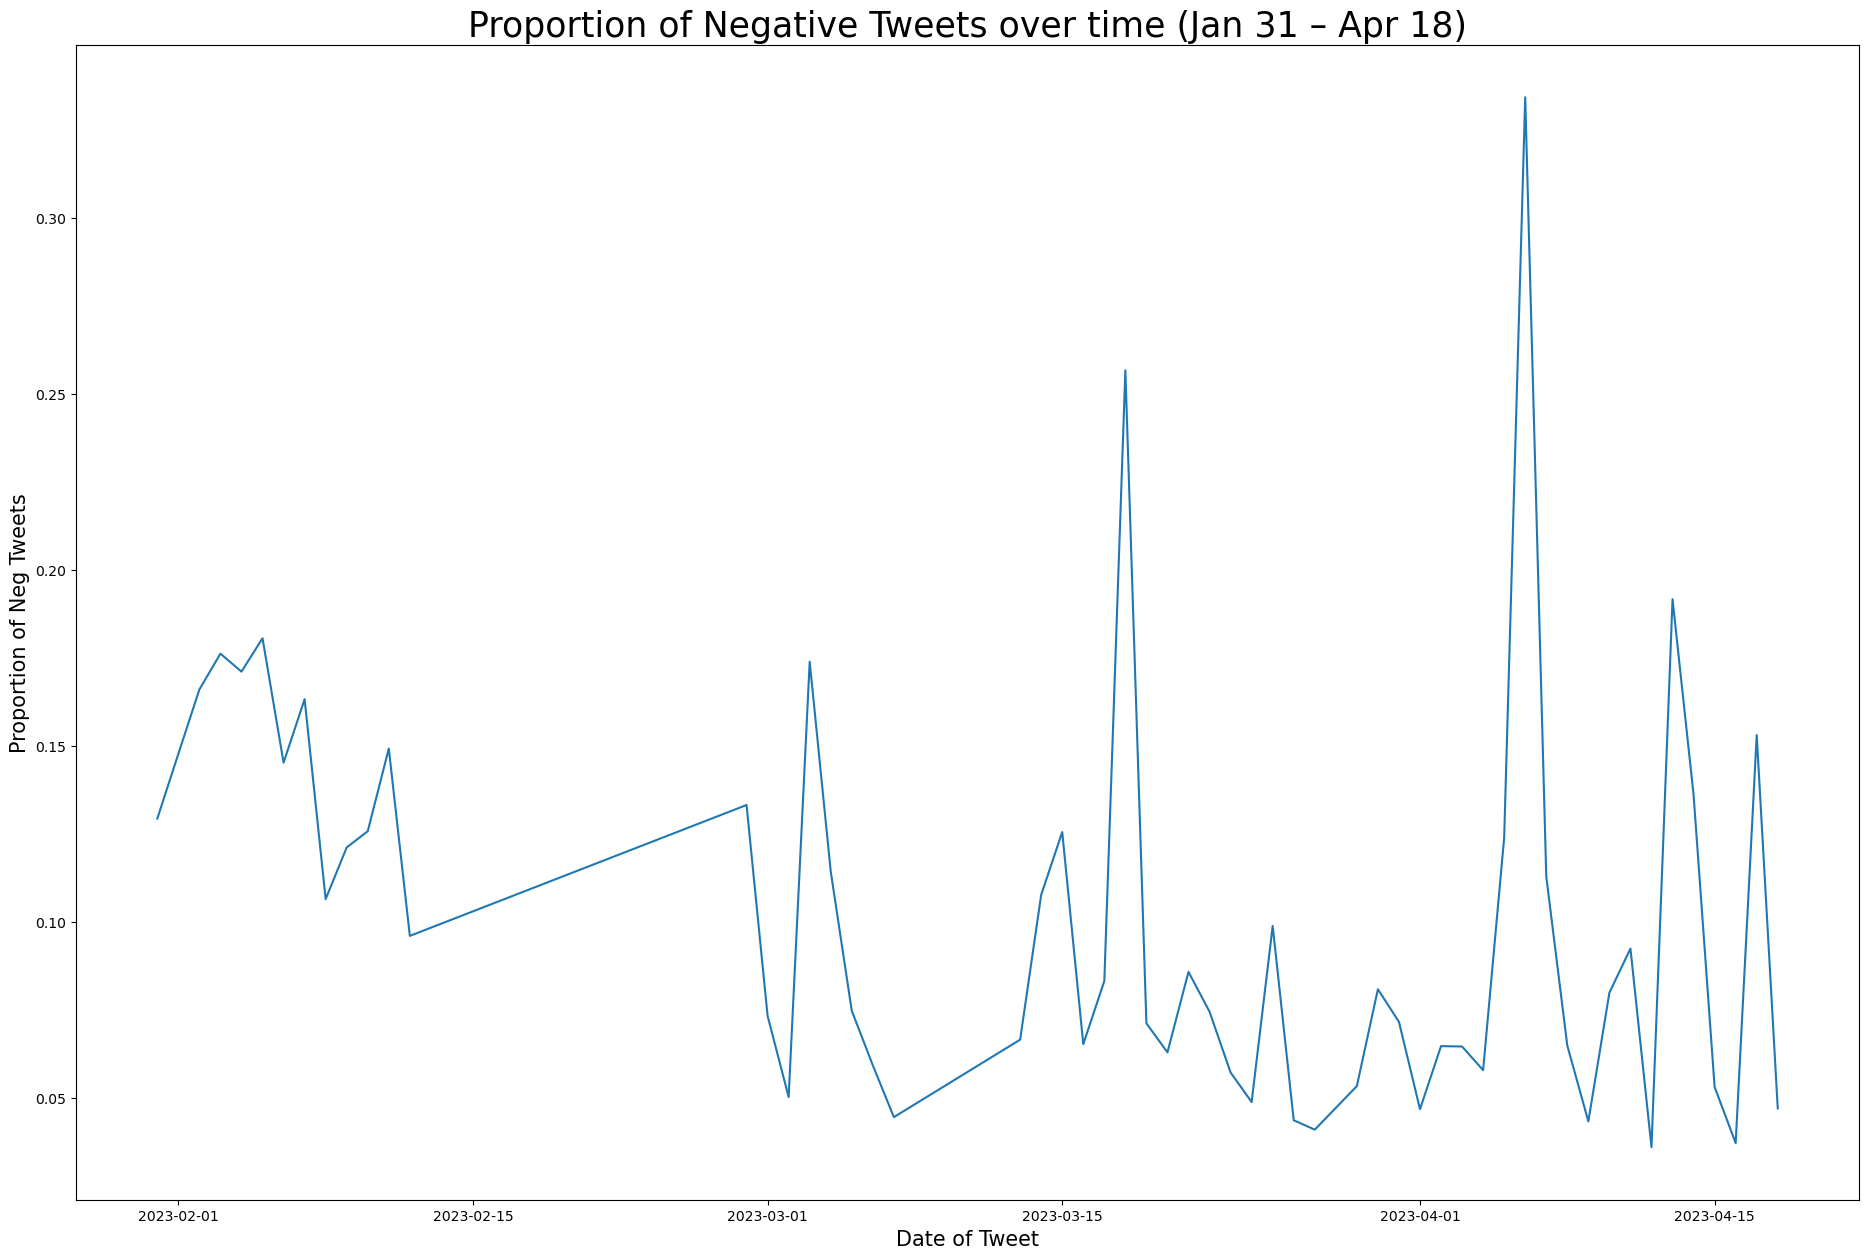

In [21]:
fig, ax = plt.subplots()
plot = sns.lineplot(data=prop_neg_tweets, x="created_at", y="tweet_sentiment")
fig.set_size_inches(23, 15)
plt.xlabel('Date of Tweet', fontsize = 15); # binned by day
plt.ylabel('Proportion of Neg Tweets', fontsize = 15);
plt.title('Proportion of Negative Tweets over time (Jan 31 – Apr 18)', fontsize = 25);

In [22]:
import datetime
prop_neg_tweets['created_at_num'] = prop_neg_tweets['created_at'].apply(lambda x: x.strftime("%Y%m%d"))

In [23]:
from sklearn.linear_model import LinearRegression

# linear regression model for proportion of negative tweets over time

X = np.array(list(prop_neg_tweets['created_at_num'].astype(int))).reshape(-1, 1)
y = list(prop_neg_tweets['tweet_sentiment'])

lr5 = LinearRegression()
lr5.fit(X, y)
print(lr5.intercept_, lr5.coef_, lr5.score(X, y))

4530.6808736124185 [-0.00022395] 0.0921717199260863


# calculate intensity of sentiment for tweets
* tokenize words in text
* nltk vader for social media text: https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/

In [24]:
# tokenize text
sf_tweets['cleaned_tweet_tok'] = [word_tokenize(t) for t in sf_tweets['cleaned_tweet']]
sf_tweets['cleaned_tweet_tok']

0        [spent, day, tenderloin, ., talked, lot, peopl...
1        [spent, day, tenderloin, ., talked, lot, peopl...
2        [spent, day, tenderloin, ., talked, lot, peopl...
3        [must, hunt, haunts, him…, haunts, (, ghost, k...
4        [available, spotify, ,, google, podcasts, ,, y...
                               ...                        
66423    [#, scifi\n, #, sf\nsf好き集まれ！！\nhttps, :, //t.c...
66424    [#, scifi\n, #, sf\nsf好き集まれ！！\nhttps, :, //t.c...
66425    [＃aiartwork, #, aiconceptart, ＃conceptart, #, ...
66426    [🍰\n\n, #, art, #, boudior, #, tuesdaymotivati...
66427    [57f, #, sf, w, scattered, clouds, &, amp, ;, ...
Name: cleaned_tweet_tok, Length: 66428, dtype: object

In [25]:
from nltk.probability import FreqDist

In [26]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [28]:
sid_obj = SentimentIntensityAnalyzer()
neg_score = []
neu_score = []
pos_score = []
for i in range(len(sf_tweets)):
    sentiment_dict = sid_obj.polarity_scores(sf_tweets['text'][i])
    neg_score.append(sentiment_dict.get('neg'))
    neu_score.append(sentiment_dict.get('neu'))
    pos_score.append(sentiment_dict.get('pos'))
sf_tweets['neg_sent_score'] = neg_score
sf_tweets['neu_sent_score'] = neu_score
sf_tweets['pos_sent_score'] = pos_score

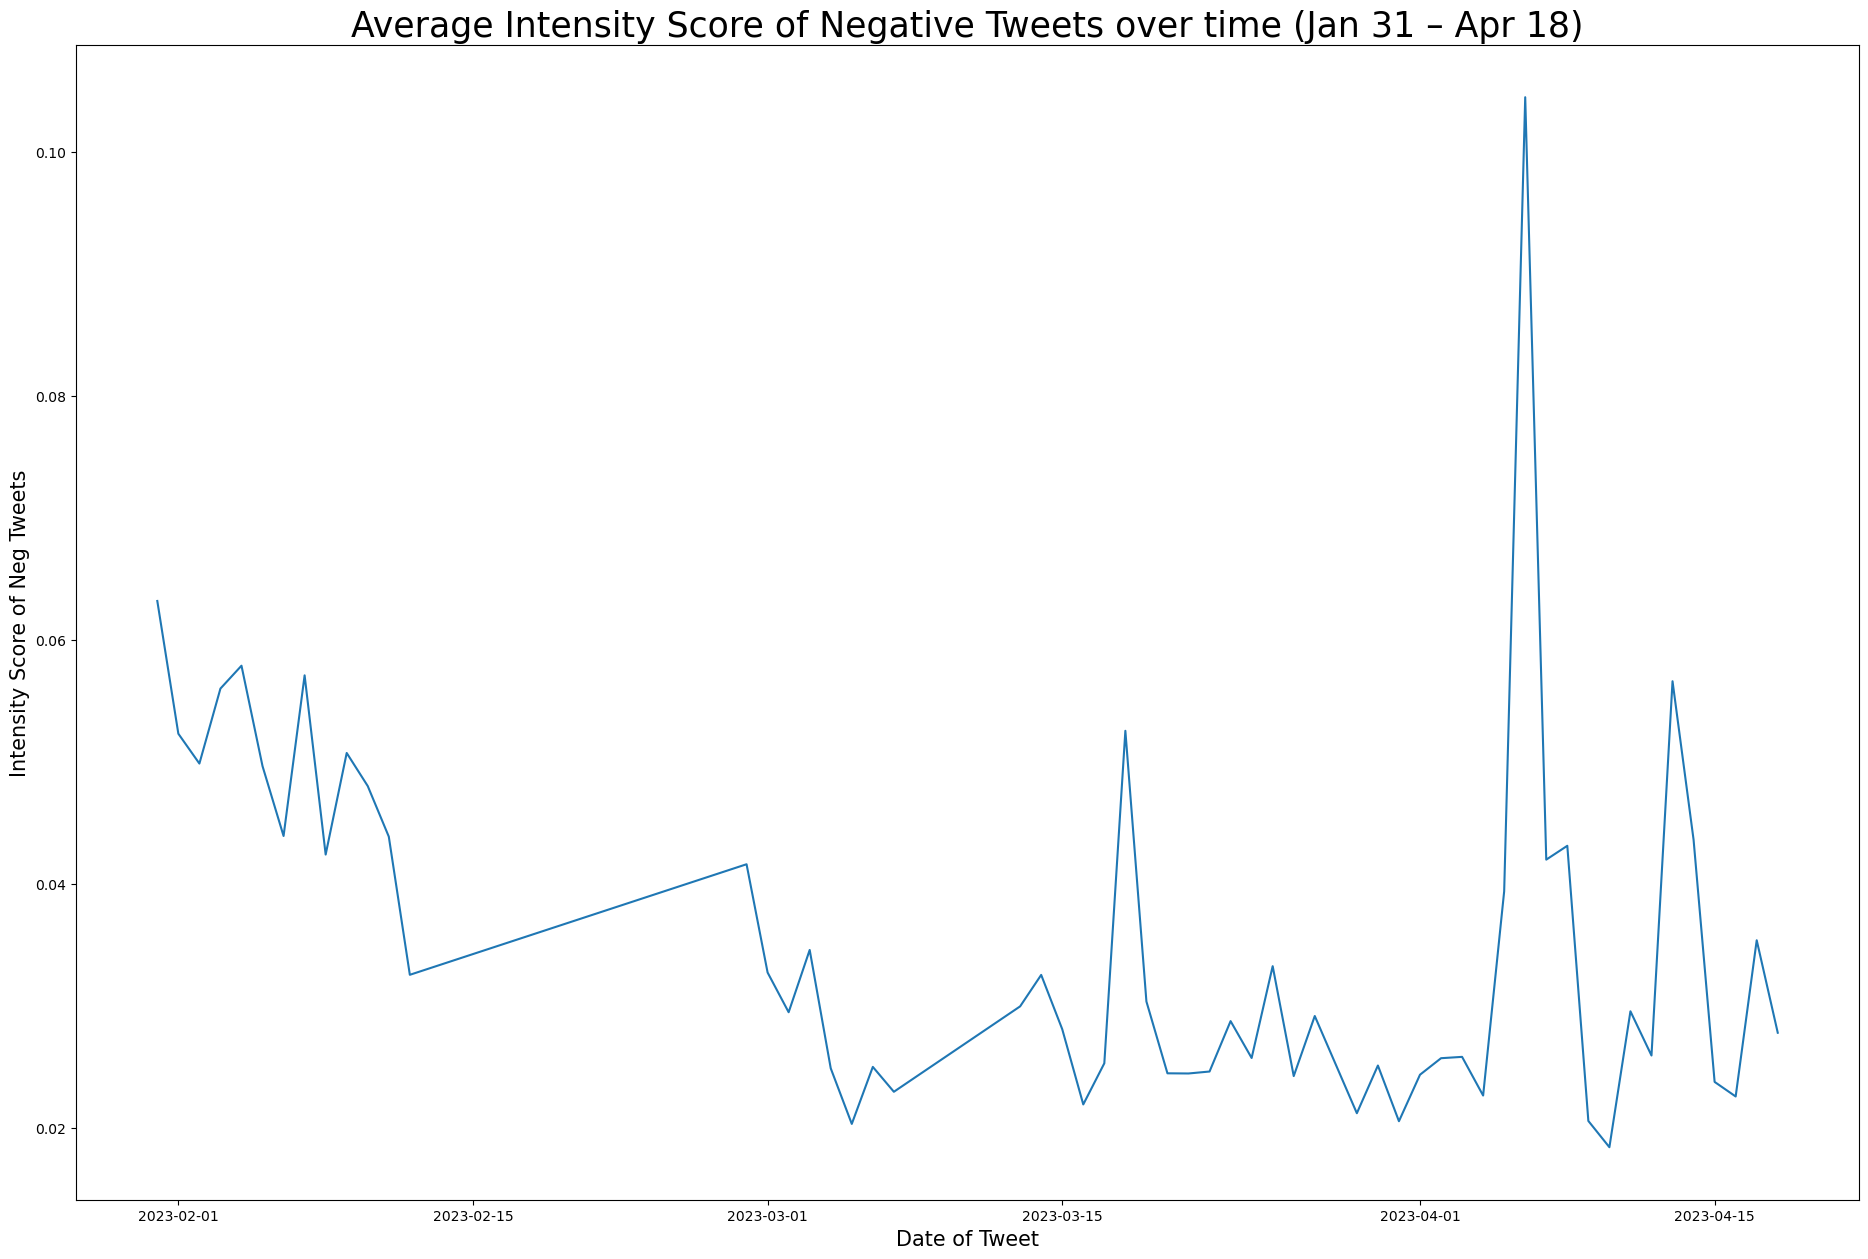

In [29]:
neg_score_df = sf_tweets[['created_at', 'neg_sent_score']].groupby('created_at').mean().reset_index()
fig, ax = plt.subplots()
plot = sns.lineplot(data=neg_score_df, x="created_at", y="neg_sent_score")
fig.set_size_inches(23, 15)
plt.xlabel('Date of Tweet', fontsize = 15); # binned by day
plt.ylabel('Intensity Score of Neg Tweets', fontsize = 15);
plt.title('Average Intensity Score of Negative Tweets over time (Jan 31 – Apr 18)', fontsize = 25);

In [30]:
sf_tweets.to_csv('sf_tweets.csv')

In [36]:
crime_df = pd.read_csv('crime_type_df.csv')

# intensity of negative sentiment for all crimes

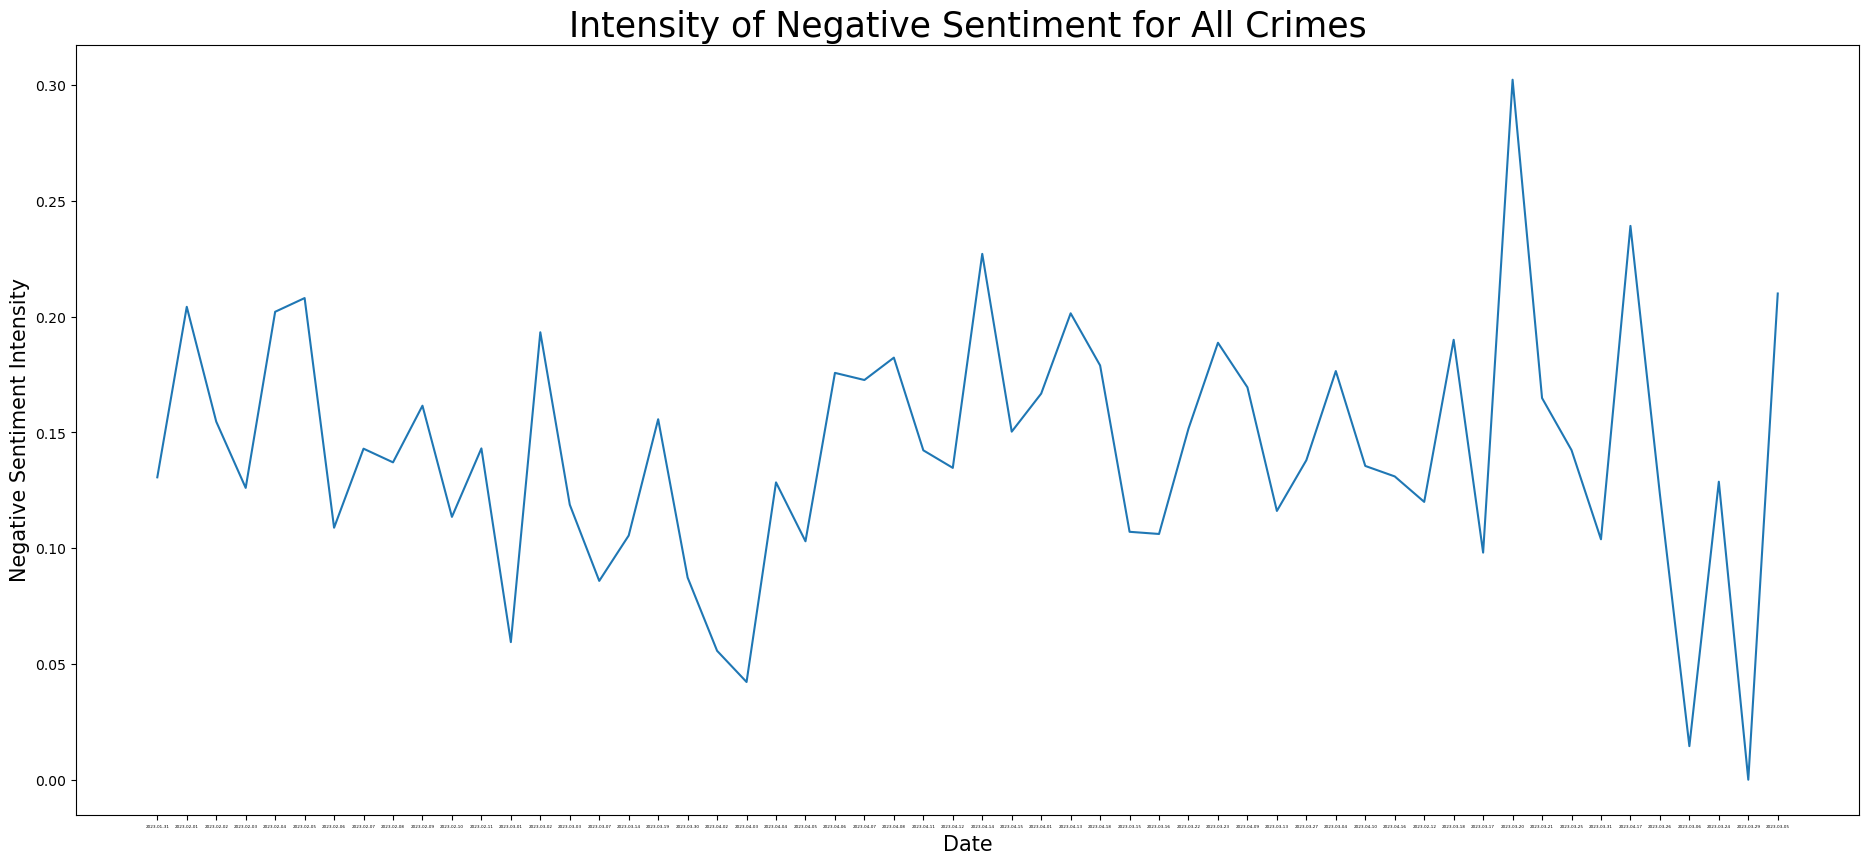

In [48]:
fig, ax = plt.subplots()
plot = sns.lineplot(data=crime_df, x="created_at", y="neg_sent_score", ci=None)
fig.set_size_inches(23, 10)
plt.xticks(fontsize=3)
plt.xlabel('Date', fontsize = 15);
plt.ylabel('Negative Sentiment Intensity', fontsize = 15);
plt.title('Intensity of Negative Sentiment for All Crimes', fontsize = 25);

# intensity of negative sentiment for diff crimes

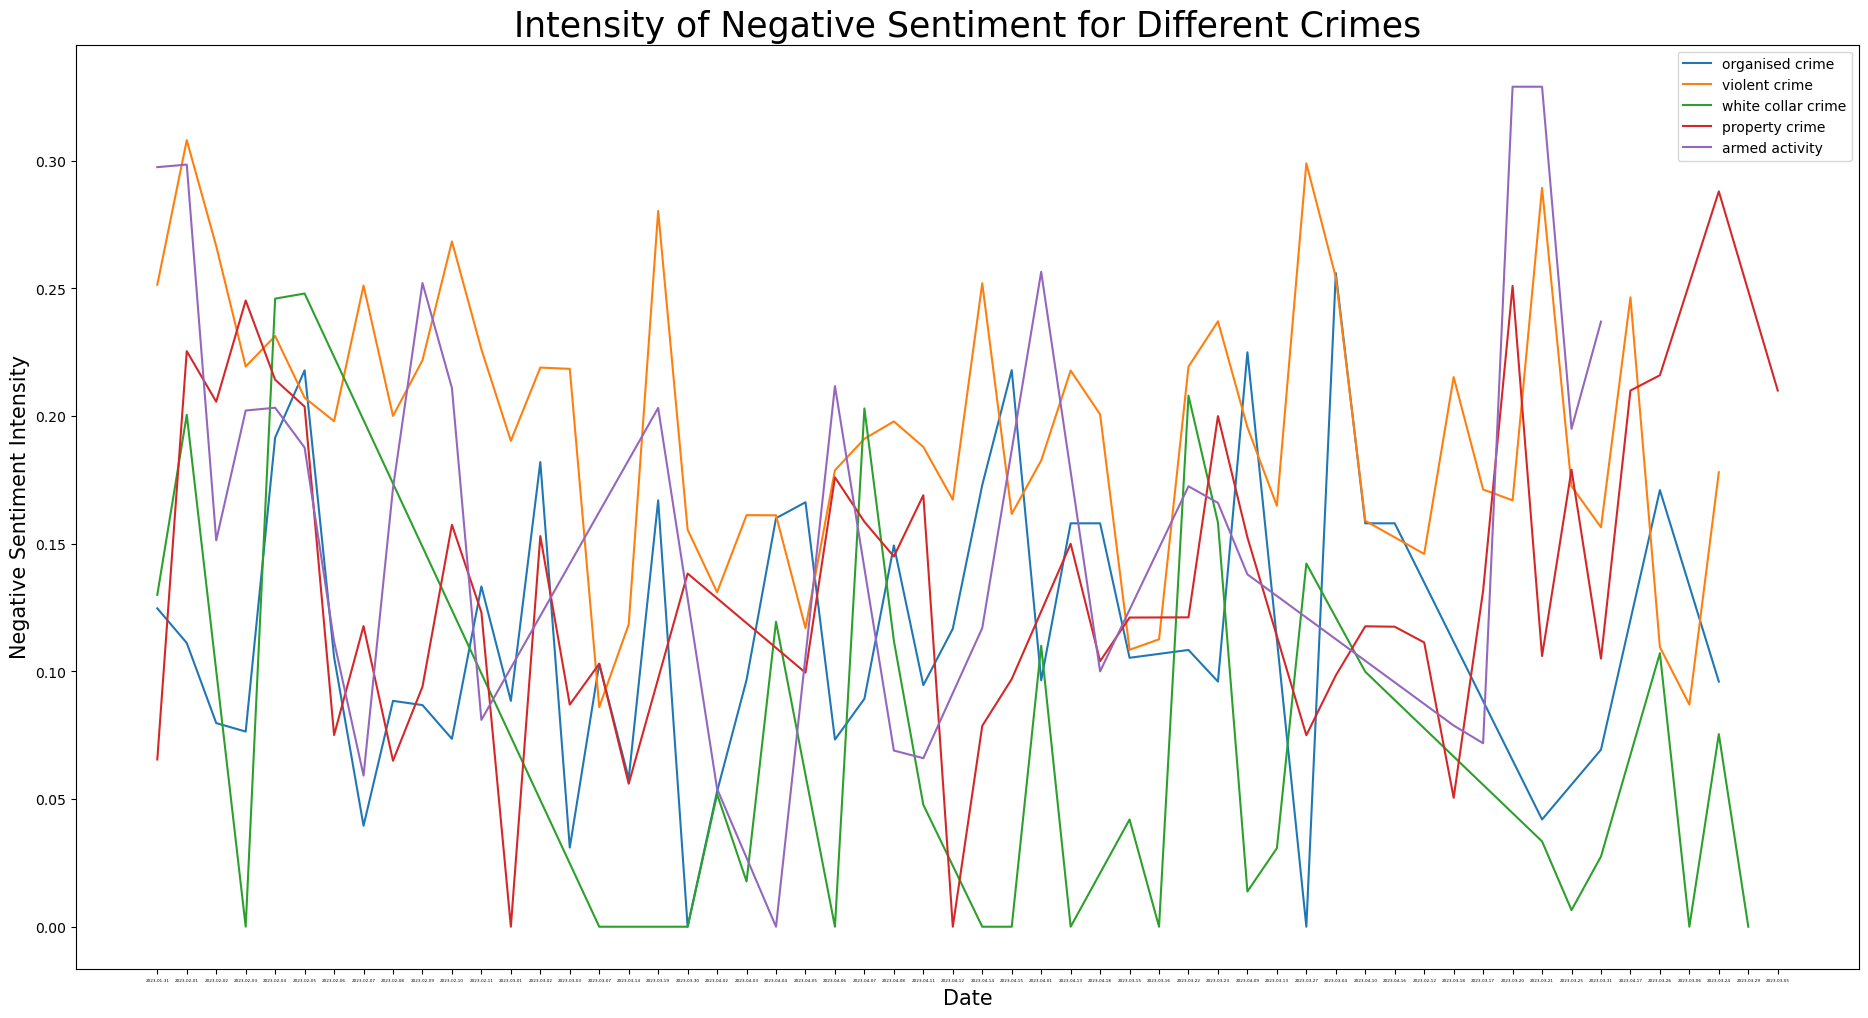

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot = sns.lineplot(data=crime_df, x="created_at", y="neg_sent_score", hue="crime type", ci=None)
fig.set_size_inches(23, 12)
plot.legend(fontsize = 10)
plt.xticks(fontsize=3)
plt.xlabel('Date', fontsize = 15); # binned by day
plt.ylabel('Negative Sentiment Intensity', fontsize = 15);
plt.title('Intensity of Negative Sentiment for Different Crimes', fontsize = 25);